In [13]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from motion_planning_utils import *
from matplotlib import pyplot as plt
import numpy as np
from shapely.geometry import Point, Polygon, LineString, box
from environment import Environment, plot_environment, plot_line, plot_poly
import pyclipper
# from pyscipopt import *
from gurobipy import *
import json


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(5.5, 5.5)


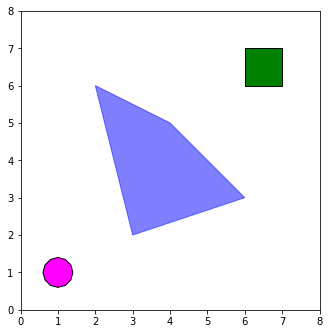

In [14]:
# Sample Problem
obstacles = [(3,2), (2,6), (4,5), (6,3)]
start = (1,1)
goal = [(6,6), (6,7), (7,7), (7, 6)]

env = Environment(None)
env.add_obstacles([Polygon(obstacles)])
bounds = (0, 0, 8, 8)
ax = plot_environment(env, bounds=bounds)
start_point = Point(start).buffer(0.4, resolution=3)
goal_region = Polygon(goal)
plot_poly(ax, start_point,'magenta')
plot_poly(ax, goal_region,'green')

In [15]:
def find_vertex_avg(obstacle):
    x_avg = sum([x[0] for x in obstacle])/len(obstacle)
    y_avg = sum([x[1] for x in obstacle])/len(obstacle)
    return (x_avg, y_avg)

In [37]:
T

30

In [55]:
# testing using Gurobi via gurobipy
start_point = (1,1)
goal_state = (7,7)
N = 120
timestep = .4
T = int(N * timestep)
time = list(range(1,N+1))
V_max = 1
M = 1e6
model = Model()
bounds = (0, 0, 8, 8)
obs_list = [[(3,2), (2,6), (4,5), (6,3)]]
# obs_list = buff_obs

# Set x,y decision vars
x,y,z = {},{},{}
for t in range(0,N+1):
    x[t] = model.addVar(lb=bounds[0], ub=bounds[2], name="x(%s)"%(t))
    y[t] = model.addVar(lb=bounds[1], ub=bounds[3], name="y(%s)"%(t))
        
# Set objective function
model.setObjective(quicksum((x[t] - x[t-1])*(x[t] - x[t-1]) + (y[t] - y[t-1])*(y[t] - y[t-1]) for t in time))

# Set initial conditions
model.addConstr(x[0] == start_point[0])
model.addConstr(y[0] == start_point[1])

# Set velocity constraint for each time period
for t in time:
    model.addQConstr((x[t] - x[t-1])*(x[t] - x[t-1]) + (y[t] - y[t-1])*(y[t] - y[t-1]) <= V_max**2 * timestep**2)
    
# Set goal state conditions
model.addConstr(x[T] == goal_state[0])
model.addConstr(y[T] == goal_state[1])
    
# Set Obstacle Constraints
for idx_obs, obs in enumerate(obs_list):
    # create z variables z_obs_len(obs)
    
    for idx_v, vertex, in enumerate(obs):
        for t in time:
            z[(idx_obs, idx_v, t)] = model.addVar(name="z(%s,%s,%s)"%(idx_obs,idx_v,t), vtype="BINARY")
        vertex1 = obs[idx_v]
        vertex2 = obs[(idx_v + 1)%len(obs)] # grab next vertex and loop back to the first for last index
        delta_x = vertex2[0] - vertex1[0]
        delta_y = vertex2[1] - vertex1[1]
        vertex_avg = find_vertex_avg(obs) # known that avg of vertices lies inside convex polygon
        if delta_x != 0:  # check if line is vertical
            m = delta_y / delta_x
            b = vertex1[1] - m * vertex1[0]
            if vertex_avg[1] < m * vertex_avg[0] + b:  # then flip constraint
                model.addConstrs(-y[t] <= -m * x[t] - b + M*z[(idx_obs, idx_v, t)] for t in time)
            else:
                model.addConstrs(y[t] <= m * x[t] + b + M*z[(idx_obs, idx_v, t)] for t in time)
        else:
            if vertex_avg[0] <= vertex1[0]:  # then flip constraint
                model.addConstrs(-x[t] <= -vertex1[0] + M*z[(idx_obs, idx_v, t)] for t in time)
            else:
                model.addConstrs(x[t] <= vertex1[0] + M*z[(idx_obs, idx_v, t)] for t in time)
    for t in time:            
        model.addConstr(quicksum(z[(idx_obs,v,t)] for v in range(len(obs))) <= (len(obs) - 1))

model.update()
model.optimize()

Optimize a model with 604 rows, 722 columns and 1924 nonzeros
Model has 482 quadratic objective terms
Model has 120 quadratic constraints
Variable types: 242 continuous, 480 integer (480 binary)
Coefficient statistics:
  Matrix range     [3e-01, 1e+06]
  QMatrix range    [1e+00, 2e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 8e+00]
  RHS range        [1e+00, 1e+01]
  QRHS range       [2e-01, 2e-01]
Presolve removed 12 rows and 11 columns
Presolve time: 0.01s
Presolved: 592 rows, 711 columns, 1894 nonzeros
Presolved model has 472 quadratic objective terms
Variable types: 238 continuous, 473 integer (473 binary)

Root relaxation: objective 1.500000e+00, 834 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    1.50000    0  270          -    1.50000      -     -    0s
     0     0    1.50000    0 

In [56]:
path_list = []
for t in time:
#     x_val.append(x[t].x)
#     y_val.append(y[t].x)
    path_list.append((x[t].x, y[t].x))

(5.5, 5.5)
Obstacle Vertices: 
 [[(3, 2), (2, 6), (4, 5), (6, 3)]]


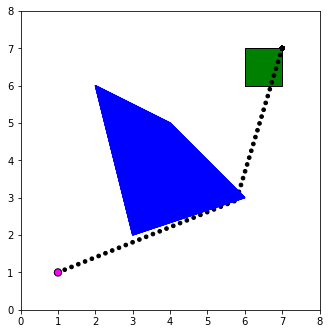

In [57]:
# Redefine obstacles with radius of droid; treat droid as a point robot
ax = plot_env([Polygon(obs_list[0])], start, goal, bounds)

for pt in path_list:
    t_pt = Point(pt).buffer(0.05, resolution=3)
    plot_poly(ax, t_pt, 'black')    


print('Obstacle Vertices: \n', obs_list)

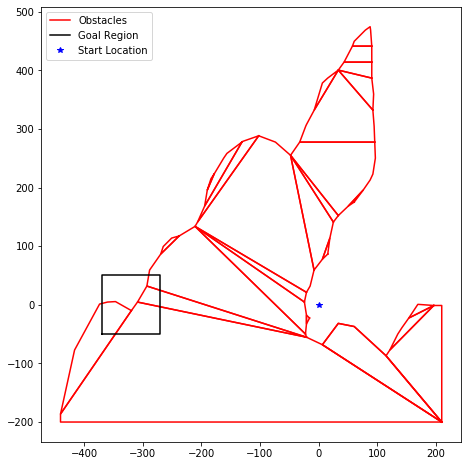

In [62]:
# Test JSON obstacle file

with open('notamoon.json') as f:
    ex_json_dict = json.load(f)
plt.figure(figsize=(14,8))

for obs in ex_json_dict['obstacles']:
    coord = np.array(obs['geometry']['coordinates'])
    plt.plot(coord[:,0],coord[:,1],'-r')

plt.gca().set_aspect('equal','box')
plt.draw()
line1,= plt.plot(coord[:,0],coord[:,1],'-r',label='Obstacles')

coord = np.array(ex_json_dict['goal']['geometry']['coordinates'])
line2,=plt.plot(coord[:,0],coord[:,1],'k-',label='Goal Region')

line3,=plt.plot(0,0,'*b',label='Start Location')
plt.legend(handles=[line1,line2,line3],loc='best')


In [68]:
obs_list_nm = []
for obs in ex_json_dict['obstacles']:
    coord = obs['geometry']['coordinates']
    obs_list_nm.append(coord)


In [70]:
len(obs_list_nm)

27

In [120]:
start_point = (0,0)
goal_state = (-350,50)
N = 20
timestep = 1
T = int(N * timestep)
time = list(range(1,N+1))
V_max = 100
M = 1e6
eps = 10
# TODO - automate bounds creation
bounds = (-550, -300, 300, 550)
# obs_list = [[(3,2), (2,6), (4,5), (6,3)]]
obs_list = obs_list_nm

model = Model()

# Set x,y decision vars
x,y,z = {},{},{}
for t in range(0,N+1):
    x[t] = model.addVar(lb=bounds[0], ub=bounds[2], name="x(%s)"%(t))
    y[t] = model.addVar(lb=bounds[1], ub=bounds[3], name="y(%s)"%(t))
        
# Set objective function
model.setObjective(quicksum((x[t] - x[t-1])*(x[t] - x[t-1]) + (y[t] - y[t-1])*(y[t] - y[t-1]) for t in time))

# Set initial conditions
model.addConstr(x[0] == start_point[0])
model.addConstr(y[0] == start_point[1])

# Set velocity constraint for each time period
for t in time:
    model.addQConstr((x[t] - x[t-1])*(x[t] - x[t-1]) + (y[t] - y[t-1])*(y[t] - y[t-1]) <= V_max**2 * timestep**2)
    
# Set goal state conditions
model.addConstr(x[T] == goal_state[0])
model.addConstr(y[T] == goal_state[1])
    
# Set Obstacle Constraints
for idx_obs, obs in enumerate(obs_list):
    # create z variables z_obs_len(obs)
    
    for idx_v, vertex, in enumerate(obs):
        for t in time:
            z[(idx_obs, idx_v, t)] = model.addVar(name="z(%s,%s,%s)"%(idx_obs,idx_v,t), vtype="BINARY")
        vertex1 = obs[idx_v]
        vertex2 = obs[(idx_v + 1)%len(obs)] # grab next vertex and loop back to the first for last index
        delta_x = vertex2[0] - vertex1[0]
        delta_y = vertex2[1] - vertex1[1]
        vertex_avg = find_vertex_avg(obs) # known that avg of vertices lies inside convex polygon
        if delta_x != 0:  # check if line is vertical
            m = delta_y / delta_x
            b = vertex1[1] - m * vertex1[0]
            if vertex_avg[1] < m * vertex_avg[0] + b:  # then flip constraint
                model.addConstrs(-y[t] <= -m * x[t] - b + M*z[(idx_obs, idx_v, t)] - eps for t in time)
            else:
                model.addConstrs(y[t] <= m * x[t] + b + M*z[(idx_obs, idx_v, t)] - eps for t in time)
        else:
            if vertex_avg[0] <= vertex1[0]:  # then flip constraint
                model.addConstrs(-x[t] <= -vertex1[0] + M*z[(idx_obs, idx_v, t)] - eps for t in time)
            else:
                model.addConstrs(x[t] <= vertex1[0] + M*z[(idx_obs, idx_v, t)] - eps for t in time)
    for t in time:            
        model.addConstr(quicksum(z[(idx_obs,v,t)] for v in range(len(obs))) <= (len(obs) - 1))

model.update()
model.optimize()

Optimize a model with 3704 rows, 3202 columns and 11864 nonzeros
Model has 82 quadratic objective terms
Model has 20 quadratic constraints
Variable types: 42 continuous, 3160 integer (3160 binary)
Coefficient statistics:
  Matrix range     [6e-02, 1e+06]
  QMatrix range    [1e+00, 2e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 6e+02]
  RHS range        [1e+00, 7e+04]
  QRHS range       [1e+04, 1e+04]
Presolve removed 348 rows and 305 columns
Presolve time: 0.03s
Presolved: 3356 rows, 2897 columns, 10743 nonzeros
Presolved model has 74 quadratic objective terms
Variable types: 38 continuous, 2859 integer (2859 binary)

Root relaxation: objective 6.250000e+03, 5296 iterations, 0.14 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 6250.00000    0 1909          - 6250.00000      -     -    0s
     0     0 6250.000

In [121]:
path_list = []
for t in time:
#     x_val.append(x[t].x)
#     y_val.append(y[t].x)
    path_list.append((x[t].x, y[t].x))

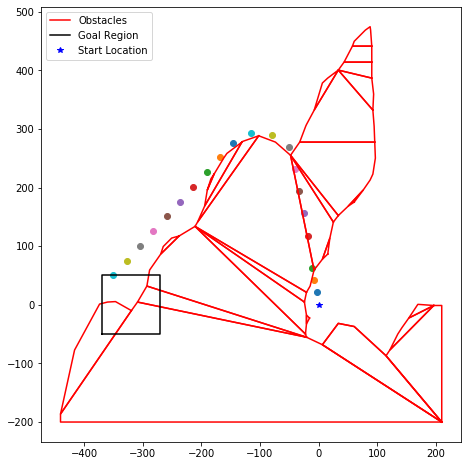

In [122]:
plt.figure(figsize=(14,8))
for obs in ex_json_dict['obstacles']:
    coord = np.array(obs['geometry']['coordinates'])
    plt.plot(coord[:,0],coord[:,1],'-r')

plt.gca().set_aspect('equal','box')
plt.draw()
line1,= plt.plot(coord[:,0],coord[:,1],'-r',label='Obstacles')

coord = np.array(ex_json_dict['goal']['geometry']['coordinates'])
line2,=plt.plot(coord[:,0],coord[:,1],'k-',label='Goal Region')

line3,=plt.plot(0,0,'*b',label='Start Location')
plt.legend(handles=[line1,line2,line3],loc='best')

for pt in path_list:
    plt.scatter(pt[0], pt[1])